## Using a Simple Logistic Regression in Python to Classify Particle Physics Events as "Signal" or "Background" Based on Two Computed Event Parameters

For the past (too many) years, I've been a graduate student working on a neutrino experiment at [Fermilab](http://www.fnal.gov/). I won't go into much detail about it in this post for two reasons:
* It isn't really relevant for this post; I'm describing how I use machine learning and logistic regression to classify _x_ based on some variables that describe _x_.
* For political reasons within my collaboration, I'm not actually allowed to publish any of my work without collaboration-wide approval.

Therefore, in this post, I will keep everything in the abstract, and I will change all variable names to agnostic things like "**variable1**" and "**variable2**".

#### Side note

This work was inspired by the [Machine Learning Coursera course by Andrew Ng](https://www.coursera.org/learn/machine-learning/home/welcome) which I have been completing along side my thesis work. That course (which I'm _really_ enjoying) has homework which can only be completed (for an official course certificate) in [MATLAB](http://www.mathworks.com/products/matlab/) or in [OCTAVE](https://en.wikipedia.org/wiki/GNU_Octave), but I've chosen to [complete it on my own](https://github.com/kaleko/CourseraML) in python/numpy. I already use (and love) python, and I understand that most data scientists are either using python or R these days. Sure, I won't end up with a certificate to pin up to my [Linkedin](https://www.linkedin.com/in/david-kaleko-73937223) but that doesn't matter much to me; I'm interested learning the course content.

#### Background

Upstream of this python analysis is a long chain of simulations, clustering, reconstruction algorithms (primarily C++), analysis modules, yadda yadda yadda. What pops out of the end is something stored in a [ROOT](https://root.cern.ch/) "[TTree](https://root.cern.ch/doc/master/classTTree.html)", which is essentially a [pandas](http://pandas.pydata.org/) "[Dataframe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)". Inside of this TTree are some variables that are computed (particle physics-)event-by-event which describe that event (you can imagine things like: location inside of the particle detector where the event started, calculated total energy deposited by the particles in the event, time of the event, number of particles reconstructed in the event, etc... there are of course much more complicated/abstract variables that might be computed, too).

I have at my disposal a simulated sample of "signal" events and a simulated sample of "background" events. In machine learning lingo, I have a fully labeled training set and am performing "supervised learning". My goal is to train a logistic regression based on two variables to determine whether an unknown (unlabeled) event is "signal" or "background".

#### The training set

To begin, I read in the TTree and turn it into a Dataframe. Then, I forget ROOT ever existed and proceed using only numpy/pandas/scipy/matplotlib. However, for the sake of keeping the variable names anonymous in this post, I have separately done this backend work and saved the relevant columns from the Dataframe to csv files. I have one csv file called "signal_sample.csv" and another called "background_sample.csv", and the two variables with which I will create a logistic regression have been named "**variable1**" and "**variable2**".

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
dfs = { 'background' : pd.DataFrame().from_csv('data/background_sample.csv'),
        'signal'     : pd.DataFrame().from_csv('data/signal_sample.csv')     }

Here you can see the appropriately anonymized variable names:

In [3]:
dfs['background'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 0 to 593
Data columns (total 2 columns):
variable1    594 non-null float64
variable2    594 non-null float64
dtypes: float64(2)
memory usage: 13.9 KB


I'll note that a lot of the work done below could almost certainly be done in many fewer lines with an already existing machine learning package. Since this work was inspired by the Coursera course I'm taking (which has me implementing all of these things by hand), I will do it the "hard way" here. That said, now that I fully understand the inner-workings of the logistic regression, I will likely use pre-existing libraries in the future.

I begin by building numpy _matrices_ from my dataframes, as much of the regression code contains a lot of linear algebra. There also involves sticking in some "1"s to serve as a "bias feature".

In [4]:
#Build the feature matrix, X, from background samples (with y = 0) 
#and signal samples (with y = 1)
bkgX = dfs['background'][['variable2', 'variable1']].as_matrix()
bkgX = np.insert(bkgX,0,1,axis=1)
bkgy = np.zeros((bkgX.shape[0],1))
sigX = dfs['signal'][['variable2', 'variable1']].as_matrix()
sigX = np.insert(sigX,0,1,axis=1)
sigy = np.ones((sigX.shape[0],1))
X = np.vstack((bkgX,sigX))
y = np.vstack((bkgy,sigy))
m = y.size # number of training samples

#### Visualizing the data

Let's have a look at a scatter plot of these two variables, both for signal and for the background sample.

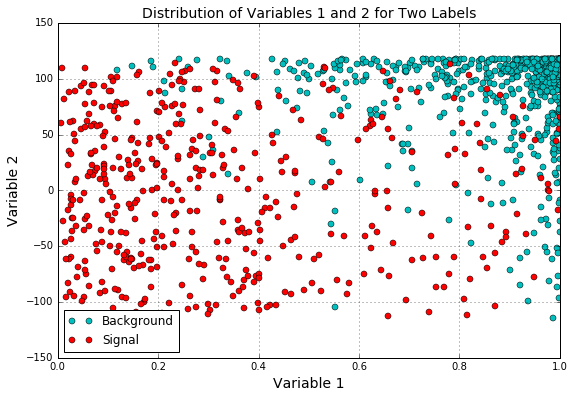

In [5]:
def plotData():
    plt.figure(figsize=(9,6))
    plt.plot(bkgX[:,1],bkgX[:,2],'co',label='Background')
    plt.plot(sigX[:,1],sigX[:,2],'ro',label='Signal')
    plt.xlabel('Variable 1',fontsize=14)
    plt.ylabel('Variable 2',fontsize=14)
    plt.title('Distribution of Variables 1 and 2 for Two Labels',
              fontsize=14)
    plt.legend(loc=3)
    plt.grid(True)
    
plotData()

It's pretty clear that some sort of diagonal decision boundary roughly connecting (0.4,100)-->(1.0,-100) would have strong separation power. My goal is to train a logistic regression and determine exactly what decision boundary is best, without overfitting the data.

Also, I see that **variable1** extends from 0 to 1, while **variable2** extends from roughly -125 to 125. The difference in ranges between the two variables calls for some feature normalization. To accomplish this, I subtract the mean and divide by the standard deviation of all samples, per feature. I store both the means and stds for later use.

In [6]:
#Feature normalizing the columns (subtract mean, divide by standard deviation)
#Note don't modify the original X matrix, use a copy
stored_feature_means, stored_feature_stds = [], []
Xnorm = X.copy()
for icol in xrange(Xnorm.shape[1]):
    #Skip the first column
    if not icol:
        stored_feature_means.append(0.)
        stored_feature_stds.append(1.)
    else: 
        stored_feature_means.append(np.mean(Xnorm[:,icol]))
        stored_feature_stds.append(np.std(Xnorm[:,icol]))
        #Faster to not recompute the mean and std again, just used stored values
        Xnorm[:,icol] = (Xnorm[:,icol] - stored_feature_means[-1]) \
        / stored_feature_stds[-1]

#### Building the regression

Now I build the logistic regression. To do this, I need a hypothesis function and a cost function. 

The hypothesis function is the equation that describes the fit. In the case of a normal linear fit ("y = mx+b"), the hypothesis function would be handed an "x" point, the real fit parameters "m" (slope) and "b" (y-intercept), and it would return _mx+b_. For a logistic regression it is slightly more complicated, but the hypothesis always returns real a number between 0 and 1. If the hypothesis is very close to "1", that means the data point you handed it is most likely classified as "1" (in our case, signal). The opposite is true if the hypothesis is close to 0.

The cost function describes how well the fit is performing, for a specific set of fit parameters. The cost is what needs to be minimized in order to find the best parameters for a fit. Essentially, you can imagine trying a billion fits with random different fit parameters, you compute the cost for each fit, and you pick the set of parameters that gave you the lowest cost (of course, this would be perhaps the least efficient minimization method, but I find it easiest to visualize). To give you an intuition for how the cost is computed, the cost function for a normal linear regression is usually the sum of the difference of squares between each data point and the linear fit value. Hence, the "best fit" line is the one with the "[least squares](https://en.wikipedia.org/wiki/Least_squares)". For a logistic regression, the cost function is again more complicated, but the intuition is the same. 

Below, my fit parameters are given by a vector called _theta_. There is also a _lambda_ term which is how I regularize my fitting. For the sake of this post, don't worry about _lamda_ because I set it to 0 (disabling regularization).

In [7]:
#Build the logistic regression:
from scipy.special import expit #Vectorized sigmoid function

#Hypothesis function and cost function for logistic regression
def h(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

#Cost function, default lambda (regularization) 0
def computeCost(mytheta,myX,myy,mylambda = 0.): 
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    Note this includes regularization, if you set mylambda to nonzero
    For the first part of the homework, the default 0. is used for mylambda
    """
    #note to self: *.shape is (rows, columns)
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:]))
    return float( (1./m) * ( np.sum(term1 - term2) + regterm ) )

#### Optimizing the fit

The only external library that I really use is the one to minimize the cost to find my optimized fit parameters. I have code to do this myself (a hand-written [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) method), but for the sake of simplicity I use a function from scipy.optimize to do it for me here. I'll note that many optimization routines need to be handed a cost function, and also a function that computes the derivative of the cost function (see the gradient descent link above). The one that I use here only needs to be given the cost function, and is therefore slower than alternatives. Since I only need to run the optimization once, and since here it still takes on the order of milliseconds, I'll stick with it.

In [8]:
#Optimization functions:
#docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin(computeCost, x0=mytheta, \
                           args=(myX, myy, mylambda), \
                           maxiter=400, full_output=True)
    return result[0], result[1]

While what I'm after are optimized fit parameters, I have to start with some initialized values that will be tuned by the minimization routine. I'll start with a vector of zeros, and see what comes out.

In [9]:
#Plug in a random initial theta and solve for the coefficients:
initial_theta = np.zeros((Xnorm.shape[1],1))
theta, mincost = optimizeTheta(initial_theta,Xnorm,y)
print theta

Optimization terminated successfully.
         Current function value: 0.227719
         Iterations: 144
         Function evaluations: 261
[-0.40574592 -2.4498874  -1.77060787]


Cool beans. Turns out if I use the printed fit parameters above, I should be able to compute a hypothesis for each data point and my machine-learned logistic regression will tell me whether that point is a signal or background. In this case since I simulated the samples myself (way upstream of this analysis), I have actual labels for each data point, so I can determine exactly how accurate my regression is.

#### Visualizing the result

This next bit isn't really necessary, but I find it pretty cool to visualize the shape of the hypothesis as a function of the two variables. If the hypothesis were as a function of one variable, this would just be a 2D line, but since I've inputted two variables into the logistic regression, it's a surface.

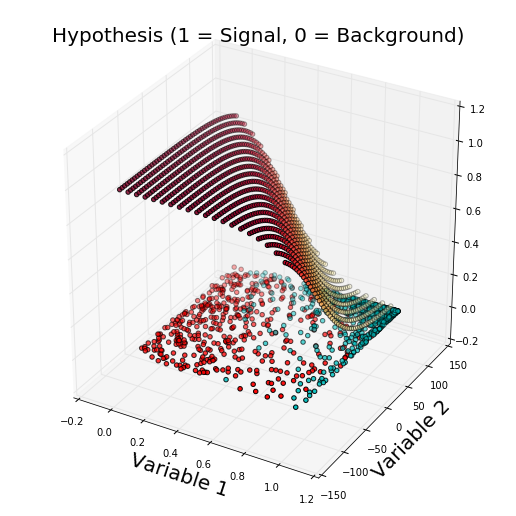

In [10]:
#Import necessary matplotlib tools for 3d plots
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')

xvals = np.arange(0,1,.05)
yvals = np.arange(-125,125,5)
myxs, myys, myzs = [], [], []
for david in xvals:
    for kaleko in yvals:
        myxs.append(david)
        myys.append(kaleko)
        testpoint = np.array([david,kaleko])
        #"undoing" feature normalization
        testpointscaled = [
            (testpoint[x]-stored_feature_means[x+1])/
            stored_feature_stds[x+1] 
            for x in xrange(len(testpoint))]
        testpointscaled.insert(0,1)
        myzs.append(h(np.array(theta),np.array([testpointscaled])))

scat = ax.scatter(myxs,myys,myzs,c=np.abs(myzs),cmap=plt.get_cmap('YlOrRd'))
blah = ax.scatter(bkgX[:,1],bkgX[:,2],np.zeros(len(bkgX[:,1])),c='c')
blah = ax.scatter(sigX[:,1],sigX[:,2],np.zeros(len(sigX[:,1])),c='r')
plt.xlabel('Variable 1',fontsize=20)
plt.ylabel('Variable 2',fontsize=20)
dummy = plt.title('Hypothesis (1 = Signal, 0 = Background)',fontsize=20)

Sweet. The surface shows that if I plug in a point like (variable1, variable2) = (0, -100), my logistic regression will return something very close to 1. That is, that region of parameter space is being classified strongly as "signal". The region near (1, 150) is classified strongly as background. Let's define a hypothesis above 0.5 as being classified as signal (and below as background), and plot the decision boundary to see if it is shaped as I predicted earlier in this post.

In [11]:
def plotBoundary(mytheta, myX, mycutval):
    """
    Function to plot the decision boundary for arbitrary theta, X, y
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    xvals = np.linspace(0,1,500)
    yvals = np.linspace(-125,125,500)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in xrange(len(xvals)):
        for j in xrange(len(yvals)):          
            testpoint = np.array([xvals[i],yvals[j]])
            testpointscaled = [(testpoint[x]-stored_feature_means[x+1]) \
                               / stored_feature_stds[x+1]
                               for x in xrange(len(testpoint))]
            testpointscaled.insert(0,1)
            zvals[i][j] = h(mytheta,testpointscaled) > float(mycutval)
    zvals = zvals.transpose()
    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    #Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Decision Boundary: h = %0.2f'%mycutval}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary",fontsize=20)

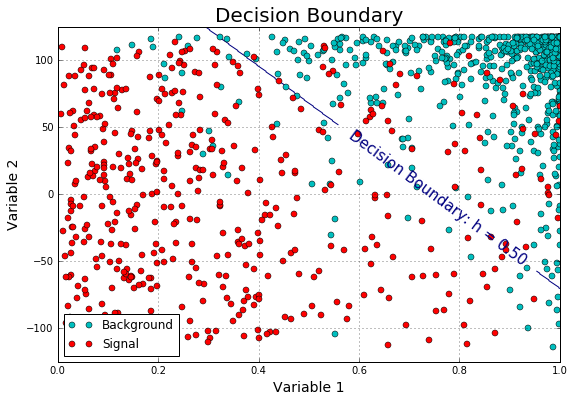

In [12]:
plotData()
plotBoundary(theta,X,0.50)

#### Interpretation

Huzzah! The location of the decision boundary makes qualitative sense. I'll note that the decision boundary is linear because my logistic regression takes only as input **variable1** and **variable2**. If I had tried more complicated combinations of these as inputs (for example, $variable1$, $variable1^2$, $variable2$, $variable2^2$, $variable1*variable2$) then the boundary may be nonlinear. While this is something I will explore in the future, for now I'm satistfied with the quality of the output and I don't have to have any worries about [overfitting](https://en.wikipedia.org/wiki/Overfitting).

In my analysis, I could do something as simple as saying "if my hypothesis is above 0.5, assume the event is signal, else assume it is background", or I could convolve the real-valued output of the hypothesis function with other separate analyses to come up with some combined likelihood event classifier.

Also, the value of "0.5" as a cutoff isn't necessarily appropriate. I can optimize this cut value by defining some "performance" metric, varying the cut value while computing the metric each time, and choosing the cut value with the highest value of the performance metric. This is, in fact, something that I do in my analysis... but, I'll save the code for a future blog post.